In [37]:
# Import system requirements
import sys, os

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

# Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [61]:
# Import data

dataset = 'asset_class' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('%s_corr.npy' % (dataset)) #list of correlation matrices for each date
dates = np.load('%s_dates.npy' % (dataset)) #list of timestamps
nodes = np.load('%s_nodes.npy' % (dataset)) #list of tickers
nodes_descr = np.load('%s_nodes_descr.npy' % (dataset)) #nested list of tickers and their descriptions/categories

num_examples = corr_tensor.shape[0] #number of dates
dim = corr_tensor.shape[1] #number of assets

[Timestamp('2008-01-31 00:00:00', freq='M')
 Timestamp('2008-02-29 00:00:00', freq='M')
 Timestamp('2008-03-31 00:00:00', freq='M')
 Timestamp('2008-04-30 00:00:00', freq='M')
 Timestamp('2008-05-31 00:00:00', freq='M')
 Timestamp('2008-06-30 00:00:00', freq='M')
 Timestamp('2008-07-31 00:00:00', freq='M')
 Timestamp('2008-08-31 00:00:00', freq='M')
 Timestamp('2008-09-30 00:00:00', freq='M')
 Timestamp('2008-10-31 00:00:00', freq='M')
 Timestamp('2008-11-30 00:00:00', freq='M')
 Timestamp('2008-12-31 00:00:00', freq='M')
 Timestamp('2009-01-31 00:00:00', freq='M')
 Timestamp('2009-02-28 00:00:00', freq='M')
 Timestamp('2009-03-31 00:00:00', freq='M')
 Timestamp('2009-04-30 00:00:00', freq='M')
 Timestamp('2009-05-31 00:00:00', freq='M')
 Timestamp('2009-06-30 00:00:00', freq='M')
 Timestamp('2009-07-31 00:00:00', freq='M')
 Timestamp('2009-08-31 00:00:00', freq='M')
 Timestamp('2009-09-30 00:00:00', freq='M')
 Timestamp('2009-10-31 00:00:00', freq='M')
 Timestamp('2009-11-30 00:00:00'

In [39]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def clique_size(clique):
    return len(clique)

In [40]:
print("num examples: %d, matrix dim: %d" % (num_examples, dim))

num examples: 120, matrix dim: 19


In [41]:
# source code for DWave max clique algorithm - modified to include timing

from __future__ import division
import networkx as nx
import dwave_networkx as dnx
from dwave_networkx.utils import binary_quadratic_model_sampler


def maximum_clique(G, sampler=None, lagrange=2.0, **sampler_args):
  
    if G is None:
        raise ValueError("Expected NetworkX graph!")

    # finding the maximum clique in a graph is equivalent to finding
    # the independent set in the complementary graph
    complement_G = nx.complement(G)
    return maximum_independent_set(complement_G, sampler, lagrange, **sampler_args)


def clique_number(G, sampler=None, lagrange=2.0, **sampler_args):
    
    return len(maximum_clique(G, sampler, lagrange, **sampler_args))


def is_clique(G, clique_nodes):

    for x in clique_nodes:
        for y in clique_nodes:
            if x != y:
                if not(G.has_edge(x,y)):
                    return False
    return True


def maximum_weighted_independent_set(G, weight=None, sampler=None, lagrange=2.0, **sampler_args):

    # Get a QUBO representation of the problem
    Q = maximum_weighted_independent_set_qubo(G, weight, lagrange)

    # use the sampler to find low energy states
    response = sampler.sample_qubo(Q, **sampler_args) #this is where the optimization happens
    computation_time = response.info['timing']['qpu_access_time'] / 10**6 #compute qpu access time, and convert to seconds 
    # we want the lowest energy sample
    sample = next(iter(response))

    # nodes that are spin up or true are exactly the ones in S.
    return [node for node in sample if sample[node] > 0], computation_time


def maximum_independent_set(G, sampler=None, lagrange=2.0, **sampler_args):

    return maximum_weighted_independent_set(G, None, sampler, lagrange, **sampler_args)


def is_independent_set(G, indep_nodes):

    return len(G.subgraph(indep_nodes).edges) == 0


def maximum_weighted_independent_set_qubo(G, weight=None, lagrange=2.0):
    
    if not G:
        return {}

    cost = dict(G.nodes(data=weight, default=1))
    scale = max(cost.values())
    Q = {(node, node): min(-cost[node] / scale, 0.0) for node in G}
    Q.update({edge: lagrange for edge in G.edges})

    return Q


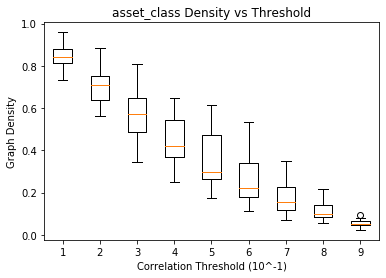

In [42]:
# Plot graph density for each threshold

thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/3)):
        corr_mat = corr_tensor[j*3, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        density_array.append(density)
    
    density_distr.append(density_array)
    
plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("%s Density vs Threshold" % (dataset))
plt.show()

In [52]:
corr_mat = corr_tensor[int(num_examples/2), :, :].copy() #take the correlation matrix for a specific date (for visualization)
corr_mat[(corr_mat > -1*0.2) & (corr_mat < 0.2)] = 0 #arbitrary threshold, for visualization purposes
G, density = make_graph(corr_mat, nodes, 'corr')

In [53]:
density

0.695906432748538

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


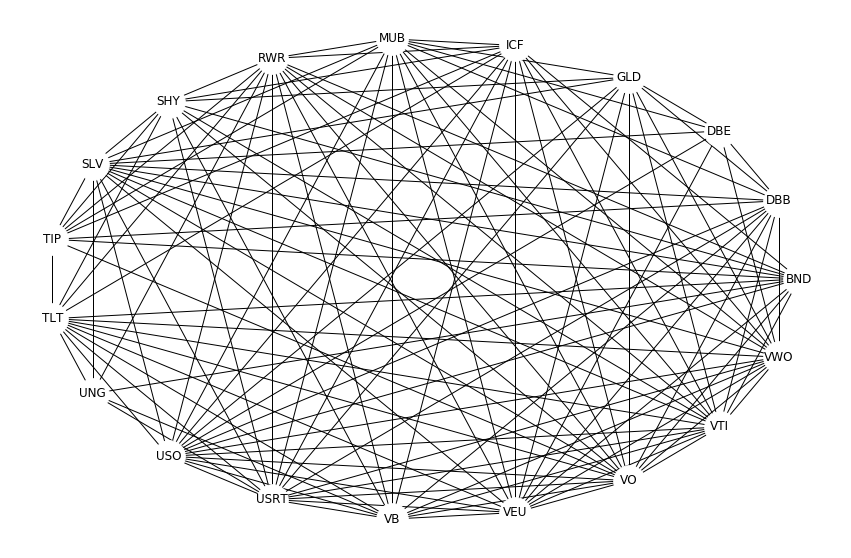

In [54]:
# Draw graph (this is only for one date)
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, node_color="white")

In [59]:
# Ensure DWave algorithm is working (just a test for one date)
max_clique, timing = maximum_clique(G, sampler)
valid_soln = dnx.is_clique(G, max_clique)

assert len(max_clique) > 0
dnx.is_clique(G, max_clique)

True

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


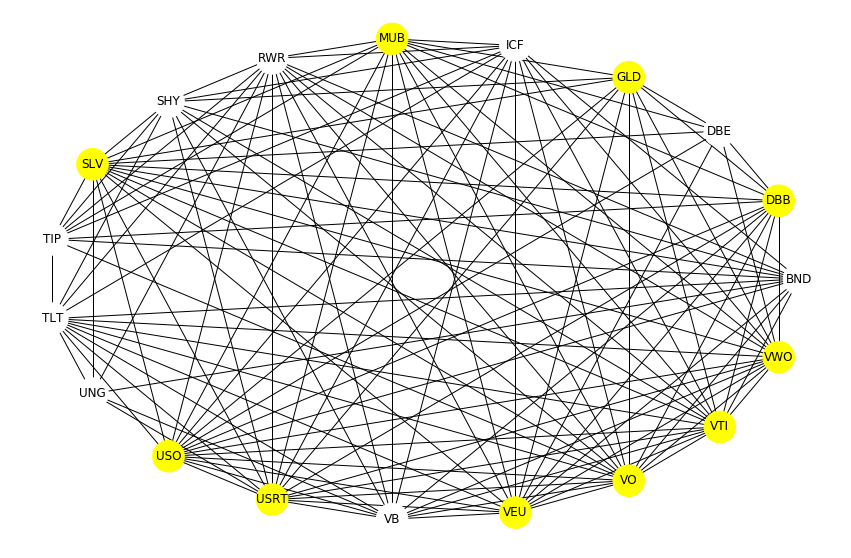

In [60]:
# Draw solution
node_coloring = []
for node in G.nodes():
    if node in max_clique:
        node_coloring.append("yellow")
    else:
        node_coloring.append("white")
        
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, 
                 node_color=node_coloring, font_color="black")

In [62]:
# Create graph for each month and calculate max clique. 

clique_array = []
valid_clique_array = []
clique_size_array = []
date_array = []
density_array = []
threshold_array = []
time_array = []

count = 0 #count to keep track of progress when running
for i in np.arange(0.1, 1, 0.1):
    for j in range(1, int(num_examples/5)): #division by 5 is just to speed up this for-loop, not necessary to have every month
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        count += 1
        if count % 10 == 0: print("count: %d" % (count))
        
        try:
            opt_clique, comp_time = maximum_clique(G, sampler)
            max_clique_size = len(opt_clique)
            valid_clique = dnx.is_clique(G, opt_clique)
            
            for k in range(3): #try a few more times to increase likelihood of getting valid clique and good clique size
                max_clique, comp_time_temp = maximum_clique(G, sampler)
                clique_size = len(max_clique)
                valid_clique = dnx.is_clique(G, max_clique)
                
                if valid_clique and clique_size > max_clique_size:
                    opt_clique = max_clique
                    max_clique_size = clique_size
                    comp_time = comp_time_temp
                
        except Exception as err:
            print(err)
            print("No embedding found for threshold %f and matrix %d" % (i, j*5))
        else: 
            clique_array.append(opt_clique)
            valid_clique_array.append(valid_clique)
            clique_size_array.append(max_clique_size)
            time_array.append(comp_time)
            threshold_array.append(i)
            density_array.append(density)
            date_array.append(dates[j*5])

count: 10
count: 20
count: 30
count: 40
count: 50
count: 60
count: 70
count: 80
count: 90
count: 100
count: 110
count: 120
count: 130
count: 140
count: 150
count: 160
count: 170
count: 180
count: 190
count: 200


In [63]:
assert len(clique_array) == len(date_array) == len(density_array) == len(threshold_array) == len(clique_size_array) == len(time_array)

In [64]:
# Create Pandas DataFrame for quantum results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array, "computation_time": time_array}).to_csv("maxclique_quant_%s_res.csv" % (dataset))

In [65]:
# Run classical max clique algm on the matrices that ran successfully above
from networkx.algorithms.approximation.clique import max_clique as class_max_clique

clique_array = []
valid_clique_array = []
clique_size_array = []
density_array = []
time_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        t = time.clock()
        max_clique = class_max_clique(G)
        elapsed = time.clock() - t
        valid_clique = dnx.is_clique(G, max_clique)
    except Exception as err:
        print(err)
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        
        clique_array.append(max_clique)
        valid_clique_array.append(valid_clique)
        clique_size_array.append(len(max_clique))
        time_array.append(elapsed)
        density_array.append(density)

In [66]:
assert len(clique_array) == len(date_array) == len(density_array) == len(threshold_array) == len(clique_size_array) == len(time_array)

In [67]:
# Create Pandas DataFrame for class results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array, "computation_time": time_array}).to_csv("maxclique_class_%s_res.csv" % (dataset))